# 0. Import Package and Configuration 

In [1]:
import random
import scipy.stats as stats
from scipy.stats import ks_2samp
import matplotlib
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time, datetime
import json
from urllib.parse import quote
import seaborn as sns
import pickle, csv
import numpy as np
import pandas as pd
import glob
import itertools
from compress_pickle import dump as cdump
from compress_pickle import load as cload
import networkx as nx
from multiprocessing import Pool
import os, sys
import numpy as np
import matplotlib.ticker as ticker
import geopandas as gpd
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import contextily as cx
import random as rand
import scipy as sp
import warnings
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

/home/jiaman/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
mode = 1; year= 0
fsize = 12; tdir = 'in'; major = 6; minor = 4; lwidth = 1; lhandle = 1
space_symbol = '                          '
mymarkersize  = 4
color_platte = ['#00429d', '#4771b2', 
'#73a2c6', '#a5d5d8', '#ffffe0', '#fcc17e', '#e0884e', '#bc4f3c', '#93003a']
plt.style.use('default')
sns.set_theme(style="white")
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.labelsize'] = fsize
plt.rcParams['ytick.labelsize'] = fsize
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams.update({'font.family':'Arial'})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_platte)

In [3]:
colors= ['#001144', '#00245a', '#013871', '#0d4c89', '#305f9e', '#4973b4', '#6087ca', '#779ce1', '#8eb2f9', '#a7caff', '#c1e4ff'][::-1]
nodes = np.arange(0,1.1,0.1)
homecmap = clr.LinearSegmentedColormap.from_list("homecmap", list(zip(nodes, colors)))

colors= ['#001819', '#012b2e', '#0a3e41', '#235255', '#386669', '#4d7b7e', '#639194', '#78a7aa', '#8fbec1', '#a5d5d8', '#bdedf0'][::-1]
nodes = np.arange(0,1.1,0.1)
workcmap = clr.LinearSegmentedColormap.from_list("workcmap", list(zip(nodes, colors)))

colors= ['#310300', '#401a00', '#532d00', '#694001', '#805313', '#976728', '#ae7b3c', '#c67550', '#dea664', '#f7bc79', '#ffd995'][::-1]
nodes = np.arange(0,1.1,0.1)
othercmap = clr.LinearSegmentedColormap.from_list("othercmap", list(zip(nodes, colors)))

colors= ['#440000', '#580000', '#700401', '#892216', '#a23929', '#bc4f3c', '#d66550', '#f17c65', '#ff937b', '#ffab91', '#ffc3a8'][::-1]
nodes = np.arange(0,1.1,0.1)
totalcmap = clr.LinearSegmentedColormap.from_list("totalcmap", list(zip(nodes, colors)))

colors= ['#00429d', '#73a2c6', '#ffffe0', '#e0884e', '#93003a']
nodes = np.arange(0,1.1,0.25)
catcmap = clr.LinearSegmentedColormap.from_list("catcmap", list(zip(nodes, colors)))

# 1. Charging Group Information

In [5]:
def read_group_file():
    p = {}
    for A in range(4):
        if A == 0:
            p[A] = pd.read_csv("data/speech/pgandsamplecode136/pg_HnoWno_n136.csv",index_col=0)
        if A == 1:
            p[A] = pd.read_csv("data/speech/pgandsamplecode136/pg_HyesWno_n136.csv",index_col=0)
        if A == 2:
            p[A] = pd.read_csv("data/speech/pgandsamplecode136/pg_HnoWyes_n136.csv",index_col=0)
        if A == 3:
            p[A] = pd.read_csv("data/speech/pgandsamplecode136/pg_HyesWyes_n136.csv",index_col=0)
    return p

def getGroup(A,D,p):
    p_a = p[A]
    prob = p_a[str(D)].values
    G = int(np.random.choice(136, 1, p=prob))
    return G  

In [6]:
df_user_inf = pickle.load(open('results/df_user_inf_update_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
df_user_inf['personConsumptionBin'] = np.clip((df_user_inf['personConsumption']*365/250).astype(int)*250, 0, 4750)
#user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
#df_user_inf = df_user_inf[df_user_inf['userID'].isin(user_select)]
A = df_user_inf['personAccess'].values
D = df_user_inf['personConsumptionBin'].values

p_g = read_group_file()
G = np.zeros(len(A))
for i in range(len(A)):
    G[i] = int(getGroup(A[i],D[i],p_g))
df_user_inf['personGroup']=G.astype(int)
df_user_inf.to_csv('results/user_group_update_'+str(mode)+'.csv',index=False)

In [7]:
p_z = {}
for nG in range(136):
    p_z[nG] = pd.read_csv('data/speech/SPEECh Original Model 136/pz_weekday_g_'+str(nG)+'.csv',index_col=0).mean()
group_feature = pd.DataFrame.from_dict(p_z).T
group_feature['home'] = group_feature['home_l2 - Fraction of weekdays with session'] + group_feature['home_l1 - Fraction of weekdays with session'] + group_feature['mud_l2 - Fraction of weekdays with session']
group_feature['work'] = group_feature['work_l2 - Fraction of weekdays with session'] 
group_feature['other'] = group_feature['public_l2 - Fraction of weekdays with session'] + group_feature['public_l3 - Fraction of weekenddays with session']
group_feature['total'] = group_feature['home']+group_feature['work']+group_feature['other']+1e-5
group_feature['home_norm'] = group_feature['home']/group_feature['total']
group_feature['work_norm'] = group_feature['work']/group_feature['total']
group_feature['other_norm'] = group_feature['other']/group_feature['total']
group_feature['home_label'] = 0; group_feature['work_label'] = 0; group_feature['other_label'] = 0; group_feature['mix_label'] = 0
threshold = 0.3
group_feature.loc[group_feature['home_norm']>threshold,'home_label'] = 1
group_feature.loc[group_feature['work_norm']>threshold,'work_label'] = 1
group_feature.loc[group_feature['other_norm']>threshold,'other_label'] = 1
group_feature['total_label'] = group_feature['other_label']+group_feature['home_label']+group_feature['work_label']
group_feature.loc[group_feature['total_label']>=2,'mix_label'] = 1
group_feature['new_label'] = group_feature[['home_norm','work_norm','other_norm']].idxmax(axis=1)
group_feature.loc[group_feature['mix_label']==1,'new_label'] = 'mix_norm'
group = df_user_inf.merge(group_feature['new_label'],left_on='personGroup',right_on=group_feature['new_label'].index)
group['new_label'] = group['new_label'].map({'home_norm': 'Home', 'work_norm': 'Work', 'other_norm': 'Public', 'mix_norm':'Mix'})

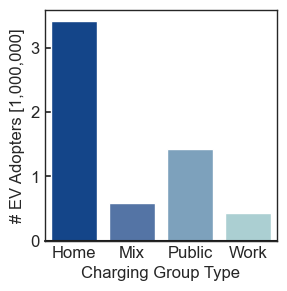

0    0.584672
1    0.098980
2    0.243807
3    0.072541
Name: 0, dtype: float64


In [8]:
group_bar = pd.pivot_table(group, values='userID', columns ='new_label',aggfunc=np.count_nonzero).sum()/1000000
group_bar = group_bar.reset_index()
f, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.barplot(data=group_bar , x='new_label', y=0, ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_xlabel("Charging Group Type")
ax.set_ylabel("# EV Adopters [1,000,000]")
plt.show()
print(group_bar[0]/sum(group_bar[0]))

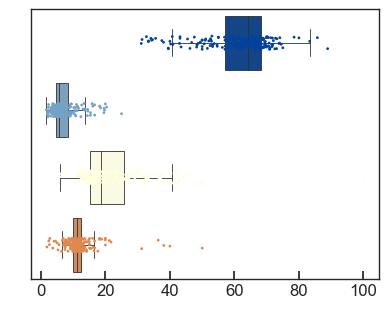

In [9]:
def getPercentage(group,rate):
    group_zipcode = pd.pivot_table(group, values='userID', index ='new_label', columns ='homeZipcode',aggfunc=np.count_nonzero).sum()
    group_zipcode_percentage = (pd.pivot_table(group, values='userID', index ='new_label', columns ='homeZipcode',aggfunc=np.count_nonzero)/group_zipcode).T*100
    group_zipcode_percentage['adoption_rate'] = rate
    return group_zipcode_percentage

user_list = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
group_num = group[group['userID'].isin(user_list)]
group_year = getPercentage(group_num,0.03)
group_year = group_year.rename(columns={'adoption_rate':'Adoption Rate [%]'})
dd=pd.melt(group_year,id_vars=['Adoption Rate [%]'],value_vars=['Home','Work','Public','Mix'],var_name='Charging Group Type').rename(columns={'value':'Percentage [%]'})
plt.figure(figsize=(4.5,3.5))
ax = sns.boxplot(x='Percentage [%]',y='Charging Group Type', data=dd,  linewidth=.6,palette=['#00429d', '#73a2c6', '#ffffe0', '#e0884e', '#93003a'],showfliers = False)
ax = sns.stripplot(x='Percentage [%]',y='Charging Group Type', data=dd, size=2, linewidth=0., orient="h",palette=['#00429d', '#73a2c6', '#ffffe0', '#e0884e', '#93003a'])
legend_elements = [Line2D([0], [0], marker='o', color=".5", label='Value', linewidth=0,
                          markerfacecolor='.5', markersize=mymarkersize),
                   Patch(facecolor='white', edgecolor='k',
                         label='Distribution')]
plt.xlabel(space_symbol)
plt.ylabel(space_symbol)
plt.xticks(fontsize=fsize)
plt.yticks([],fontsize=fsize)
plt.savefig('figures/fig2_violin_group.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

# 3. Simulate the Charging Behavior

## 3.1 Simulation

In [ ]:
p_zw = read_week_segment_file(); p_ze = read_weekend_segment_file()
p_sw = read_week_session_file(); p_se = read_weekend_session_file()
userTraj_time = pickle.load(open('results/userTraj_time_week.pkl', 'rb'), encoding='bytes')
userTraj_label = pickle.load(open('results/userTraj_label_week.pkl', 'rb'), encoding='bytes')
userTraj_zipcode = pickle.load(open('results/userTraj_zipcode_week.pkl', 'rb'), encoding='bytes')
userTraj_rtime = pickle.load(open('results/userTraj_rtime_all.pkl', 'rb'), encoding='bytes')
userTraj_energy = pickle.load(open('results/userTraj_energy_all.pkl', 'rb'), encoding='bytes')
userTraj_rdis = pickle.load(open('results/userTraj_rdis_all.pkl', 'rb'), encoding='bytes')
userTraj_route_time = pickle.load(open('results/userTraj_route_time.pkl', 'rb'), encoding='bytes')

df_user_inf = pd.read_csv('results/user_group_update_'+str(mode)+'.csv')
G = df_user_inf['personGroup'].values
U = df_user_inf['userID'].values
H = df_user_inf['personHouse'].values
W = df_user_inf['personAccess_w'].values
L = df_user_inf['personAccess_hl1'].values
user_num = len(G); run_core = 24

In [10]:
def read_week_segment_file():
    p = {}
    for G in range(136):
        p[G] = pd.read_csv('data/speech/SPEECh Original Model 136/pz_weekday_g_'+str(G)+'.csv')
    return p

def read_weekend_segment_file():
    p = {}
    for G in range(136):
        p[G] = pd.read_csv('data/speech/SPEECh Original Model 136/pz_weekend_g_'+str(G)+'.csv')
    return p

def read_week_session_file():
    p = {}
    for G in range(136):
        p[G] = {}
        for z in ['home_l2','mud_l2','work_l2','public_l2','public_l3']:
            key = 'data/speech/SPEECh Original Model 136/GMMs/weekday_'+z+'_'+str(G)+'.p'
            try:
                p[G][z] = pickle.load(open(key, "rb"))
            except:
                continue
    return p

def read_weekend_session_file():
    p = {}
    for G in range(136):
        p[G] = {}
        for z in ['home_l2','mud_l2','work_l2','public_l2','public_l3']:
            key = 'data/speech/SPEECh Original Model 136/GMMs/weekend_'+z+'_'+str(G)+'.p'
            try:
                p[G][z] = pickle.load(open(key, "rb"))
            except:
                continue
    return p 

def getSegment(G,homes,works,levels,days,stays,p_zw,p_ze):
    choice_day = []
    choice_prob = []
    choice_type = []
    
    for stay,day in zip(stays,days):
        if (day != 5) and (day != 6):
            p = p_zw[G]
            if stay == 'h':
                if homes==0:
                    type_list = ['home_l2 - Fraction of weekdays with session','public_l3 - Fraction of weekdays with session','public_l2 - Fraction of weekdays with session']
                else:
                    type_list = ['mud_l2 - Fraction of weekdays with session','public_l3 - Fraction of weekdays with session','public_l2 - Fraction of weekdays with session']
            if stay == 'w':
                if works==0:
                    type_list = ['public_l3 - Fraction of weekdays with session','public_l2 - Fraction of weekdays with session']
                else:
                    type_list = ['work_l2 - Fraction of weekdays with session','public_l3 - Fraction of weekdays with session','public_l2 - Fraction of weekdays with session']
            if stay[0] == 'o':
                type_list = ['public_l3 - Fraction of weekdays with session','public_l2 - Fraction of weekdays with session']
        else:
            p = p_ze[G]
            if stay == 'h':
                if homes==0:
                    type_list = ['home_l2 - Fraction of weekenddays with session','public_l3 - Fraction of weekenddays with session','public_l2 - Fraction of weekenddays with session']
                else:
                    type_list = ['mud_l2 - Fraction of weekenddays with session','public_l3 - Fraction of weekenddays with session','public_l2 - Fraction of weekenddays with session']
            if stay == 'w':
                if works==0:
                    type_list = ['public_l3 - Fraction of weekenddays with session','public_l2 - Fraction of weekenddays with session']
                else:
                    type_list = ['work_l2 - Fraction of weekenddays with session', 'public_l3 - Fraction of weekenddays with session', 'public_l2 - Fraction of weekenddays with session']
            if stay[0] == 'o':
                type_list = ['public_l3 - Fraction of weekenddays with session','public_l2 - Fraction of weekenddays with session']
        
        freq_mean = np.mean(p[type_list].values,axis=0)
        target_type = type_list[np.argmax(freq_mean, axis=0)].split(' ')[0]
        if target_type == 'home_l2' and levels==1:
            target_type = 'home_l1'
        target_prob = np.max(freq_mean)
        target_choice = np.random.choice(2, 1, p=[1-target_prob,target_prob])[0]

        choice_day.append(target_choice)
        choice_type.append(target_type)
        if target_prob==0:
            choice_prob.append(target_prob)
        else: 
            choice_prob.append(1/target_prob)
    return choice_day,choice_prob,choice_type

def getSession(G,zs,ztypes,stays,days,p_sw,p_se):
    energy_day = np.zeros(len(zs))
    for day,stay,z,types,i in zip(days,stays,zs,ztypes,range(len(zs))):
        if types in ['home_l1']:
            types = 'home_l2'
        if z == 1 and i != 0:
            if (day != 5) and (day != 6):
                try:
                    p_s = p_sw[G][types]
                    energy_day[i] = np.clip(p_s.sample(1)[0][0, 1], 0, 100)
                except:
                    if types in ['home_l2']:
                        p_s = p_sw[96][types]
                    elif types in ['mud_l2']:
                        p_s = p_sw[95][types]
                    elif types in ['work_l2']:
                        p_s = p_sw[98][types]
                    elif types in ['public_l2','public_l3']:
                        p_s = p_sw[105][types]
                    energy_day[i] = np.clip(p_s.sample(1)[0][0, 1], 0, 100)
            else:
                try:
                    p_s = p_se[G][types]
                    energy_day[i] = np.clip(p_s.sample(1)[0][0, 1], 0, 100)
                except:
                    if types in ['home_l2']:
                        p_s = p_se[96][types]
                    elif types in ['mud_l2']:
                        p_s = p_se[95][types]
                    elif types in ['work_l2']:
                        p_s = p_se[98][types]
                    elif types in ['public_l2','public_l3']:
                        p_s = p_se[105][types]
                    energy_day[i] = np.clip(p_s.sample(1)[0][0, 1], 0, 100) 
    return np.array(energy_day)

def parallelize_dataframe(args, func, n_cores):
    pool = Pool(n_cores)
    results = pool.map(func,args)
    pool.close()
    pool.join()
    return results

def calSession(batch_id):
    total_batch = range(len(A))
    user_select_batch = total_batch[batch_id*np.ceil(user_num/run_core).astype(int):(batch_id+1)*np.ceil(user_num/run_core).astype(int)]

    userTraj_session = {}; userTraj_days = {}; userTraj_type = {}
    for i in user_select_batch:
        stays = userTraj_label[U[i]]
        days = (np.array(userTraj_time[U[i]])/144).astype(int)
        z_s,z_prob,z_type = getSegment(G[i],H[i],W[i],L[i],days,stays,p_zw,p_ze)
        simulate = getSession(G[i],z_s,z_type,stays,days,p_sw,p_se)
        userTraj_session[U[i]] = simulate
        userTraj_type[U[i]] = z_type
        userTraj_days[U[i]] = z_prob
    
    pickle.dump(userTraj_session, open('results/userTraj_session_update_'+str(mode)+'_'+str(batch_id)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
    pickle.dump(userTraj_days, open('results/userTraj_days_update_'+str(mode)+'_'+str(batch_id)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
    pickle.dump(userTraj_type, open('results/userTraj_type_update_'+str(mode)+'_'+str(batch_id)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)


In [16]:
results = parallelize_dataframe([bathch_id for bathch_id in range(24)],calSession, n_cores=24)
userTraj_session = {}
for batch_id in range(24):
    userTraj_session.update(pickle.load(open('results/userTraj_session_update_'+str(mode)+'_'+str(batch_id)+'.pkl', 'rb'), encoding='bytes'))
pickle.dump(userTraj_session, open('results/userTraj_session_update_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)

userTraj_days = {}
for batch_id in range(24):
    userTraj_days.update(pickle.load(open('results/userTraj_days_update_'+str(mode)+'_'+str(batch_id)+'.pkl', 'rb'), encoding='bytes'))
pickle.dump(userTraj_days, open('results/userTraj_days_update_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)

userTraj_type = {}
for batch_id in range(24):
    userTraj_type.update(pickle.load(open('results/userTraj_type_update_'+str(mode)+'_'+str(batch_id)+'.pkl', 'rb'), encoding='bytes'))
pickle.dump(userTraj_type, open('results/userTraj_type_update_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)


In [17]:
# userTraj_session = pickle.load(open('results/userTraj_session_update_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
# userTraj_type = pickle.load(open('results/userTraj_type_update_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
# userTraj_label = pickle.load(open('results/userTraj_label_week.pkl', 'rb'), encoding='bytes')
# userTraj_zipcode = pickle.load(open('results/userTraj_zipcode_week.pkl', 'rb'), encoding='bytes')

tes = 21077; nis = 11470; 
prob_sum = nis+tes
type_prob = [tes/prob_sum, nis/prob_sum] 

user_id = []; stay_type = []; stay_zipcode = []; arrive_time = []; depature_time = []; session_energy = []; session_type = []
userTraj_session_timegeo = {}; userTraj_energy_timegeo = {}; userTraj_soc_timegeo={}; userTraj_cartype_timegeo={}; userTraj_capacity_timegeo={}
session_rate = {'home_l1':1.2, 'home_l2':6.6, 'mud_l2':6.6, 'work_l2':6.6, 'public_l2':6.6, 'public_l3':50}
userTraj_route_energy = pickle.load(open('results/userTraj_route_energy.pkl', 'rb'), encoding='bytes')

for id in list(U): 
    energy = np.concatenate([np.array(userTraj_route_energy[id]),np.array([0])]).copy()
    car_type = np.random.choice(2, 1, p = type_prob)[0]

    if car_type == 0:
        capacity = 82
        factor = 0.25/0.3
        energy = energy*factor
    if car_type == 1:
        capacity = 40
        factor = 1
        energy = energy*factor
        
    split = (userTraj_session[id])/(sum(userTraj_session[id])+1e-5)
    session = split*np.sum(energy)

    capacity_upper = 1; capacity_lower = 0.2; delta = []; 
    soc_start = np.clip(np.random.normal(capacity*0.8, capacity*0.2, 1)[0],capacity_lower*capacity,capacity_upper*capacity)

    travel_time = np.ceil(userTraj_route_time[id]*6)
    for i in range(len(session)):
        try:
            dtime = userTraj_time[id][i+1]
            dept = userTraj_time[id][i+1]
        except:
            dtime = 144*7
            dept = 144*7
        if i>0:
            arvt = min(userTraj_time[id][i]+travel_time[i-1],dtime)
        else:
            arvt = 1
        session[i] = min(session[i],(dept-arvt)/6*session_rate[userTraj_type[id][i]])

        cum = soc_start+sum(session[:i+1])-sum(energy[:i+1])
        if cum>capacity*capacity_upper:
            session[i] = session[i] - (cum-capacity*capacity_upper)
        if cum<capacity*capacity_lower:
            energy[i] = energy[i]-(capacity*capacity_lower-cum)
        delta.append(session[i])
        delta.append(-energy[i])
    soc_net = np.cumsum(delta)

    userTraj_session_timegeo[id] = session
    userTraj_energy_timegeo[id] = energy
    userTraj_soc_timegeo[id] = soc_start+soc_net
    userTraj_cartype_timegeo[id] = car_type
    userTraj_capacity_timegeo[id] = capacity

    for i in range(len(userTraj_label[id])):
        try:
            user_id.append(id)
            session_energy.append(session[i])
            stay_type.append(userTraj_label[id][i])
            stay_zipcode.append(userTraj_zipcode[id][i])
            session_type.append(userTraj_type[id][i])
            try:
                dtime = userTraj_time[id][i+1]
                depature_time.append(userTraj_time[id][i+1])
            except:
                dtime = 144*7
                depature_time.append(144*7)
            if i>0:
                arrive_time.append(min(userTraj_time[id][i]+travel_time[i-1],dtime))
            else:
                arrive_time.append(1)
        except:
            continue

pickle.dump(userTraj_session_timegeo, open('results/userTraj_session_timegeo_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(userTraj_energy_timegeo, open('results/userTraj_energy_timegeo_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(userTraj_soc_timegeo, open('results/userTraj_soc_timegeo_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(userTraj_cartype_timegeo, open('results/userTraj_cartype_timegeo_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(userTraj_capacity_timegeo, open('results/userTraj_capacity_timegeo_'+str(mode)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)

df = pd.DataFrame(data={'id': user_id,'arrive_time': arrive_time, 'depature_time':depature_time, 'session_energy':session_energy, 'stay_type':stay_type, 'stay_zipcode':stay_zipcode, 'session_type': session_type}) 
df = df.merge(df_user_inf[['userID','personAccess_hl1','personAccess_hl2']],right_on='userID',left_on='id')	
df.to_csv('results/simulated_session_update_'+str(mode)+'.csv',index = False)

## 3.2 Visualization

In [162]:
peak_start = 17; peak_end=21
week_peak = np.zeros(168); week_offpeak = np.zeros(168)
for hour in range(168):
    if hour<24*5:
        if (hour%24 > peak_start) and (hour%24 < peak_end):
            week_peak[hour] = 1
        elif (hour%24 == peak_start) or (hour%24 == peak_end):
            week_peak[hour] = 1
            week_offpeak[hour] = 1
        else:
            week_offpeak[hour] = 1
    else:
        week_offpeak[hour] = 1        

In [44]:
def simEVLoad(year,df):
    home_l2_rate = 6.6
    work_l2_rate = 6.6
    mud_l2_rate = 6.6
    public_l2_rate = 6.6
    home_l1_rate = 1.2
    public_l3_rate = 50
    dayhour = 24*7

    user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
    df = df[df['id'].isin(user_select)]

    df_home_l1 = df[(df['session_type']=='home_l1')]
    df_home_l1['charge_end_time'] = np.minimum(df_home_l1['arrive_time']+(df_home_l1['session_energy']/home_l1_rate)*6,df_home_l1['depature_time'])

    df_home_l2 = df[(df['session_type']=='home_l2')]
    df_home_l2['charge_end_time'] = np.minimum(df_home_l2['arrive_time']+(df_home_l2['session_energy']/home_l2_rate)*6,df_home_l2['depature_time'])
    
    df_home_l3 = df[(df['session_type']=='mud_l2')]
    df_home_l3['charge_end_time'] = np.minimum(df_home_l3['arrive_time']+(df_home_l3['session_energy']/mud_l2_rate)*6,df_home_l3['depature_time'])
    df_work = df[(df['session_type']=='work_l2')]
    df_work['charge_end_time'] = np.minimum(df_work['arrive_time']+(df_work['session_energy']/work_l2_rate)*6,df_work['depature_time'])
    
    df_other_l2 = df[df['session_type']=='public_l2']
    df_other_l2['charge_end_time'] = np.minimum(df_other_l2['arrive_time']+(df_other_l2['session_energy']/public_l2_rate)*6,df_other_l2['depature_time'])
    df_other_l3 = df[df['session_type']=='public_l3']
    df_other_l3['charge_end_time'] = np.minimum(df_other_l3['arrive_time']+(df_other_l3['session_energy']/public_l3_rate)*6,df_other_l3['depature_time'])

    zipcode_list = df['stay_zipcode'].unique()
    home_demand_l1 = {}; home_demand_l2 = {}; home_demand_l3 = {}; work_demand = {}; other_demand_l2 = {}; other_demand_l3 = {}; 
    total_demand = {}; home_demand = {}; other_demand = {}

    for zipcode in zipcode_list:
        df_home_1 = df_home_l1[(df_home_l1['session_energy']!=0)&(df_home_l1['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l1_rate
        home_demand_l1[zipcode] = np.sum(home_matrix,axis=0)

        df_home_1 = df_home_l2[(df_home_l2['session_energy']!=0)&(df_home_l2['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l2_rate
        home_demand_l2[zipcode] = np.sum(home_matrix,axis=0)

        df_home_1 = df_home_l3[(df_home_l3['session_energy']!=0)&(df_home_l3['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = mud_l2_rate
        home_demand_l3[zipcode] = np.sum(home_matrix,axis=0)

        df_work_1 = df_work[(df_work['session_energy']!=0)&(df_work['stay_zipcode']==zipcode)]
        start_time =(df_work_1['arrive_time']/6).astype(int).values
        end_time = (df_work_1['charge_end_time']/6).astype(int).values
        work_matrix = np.zeros((len(df_work_1),dayhour))
        for i in range(len(start_time)):
            work_matrix[i,start_time[i]:end_time[i]+1] = work_l2_rate
        work_demand[zipcode] = np.sum(work_matrix,axis=0)

        df_other_1 = df_other_l2[(df_other_l2['session_energy']!=0)&(df_other_l2['stay_zipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),dayhour))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l2_rate
        other_demand_l2[zipcode] = np.sum(other_matrix,axis=0)

        df_other_1 = df_other_l3[(df_other_l3['session_energy']!=0)&(df_other_l3['stay_zipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),dayhour))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l3_rate
        other_demand_l3[zipcode] = np.sum(other_matrix,axis=0)

        home_demand[zipcode] = home_demand_l1[zipcode]+home_demand_l2[zipcode]+home_demand_l3[zipcode]
        other_demand[zipcode] = other_demand_l3[zipcode]+other_demand_l2[zipcode]
        total_demand[zipcode] = work_demand[zipcode]+other_demand[zipcode]+home_demand[zipcode]
    
    home = pd.DataFrame.from_dict(home_demand, orient='index')
    work = pd.DataFrame.from_dict(work_demand, orient='index')
    other = pd.DataFrame.from_dict(other_demand, orient='index')
    total = pd.DataFrame.from_dict(total_demand, orient='index')
    return home, work, other, total

In [164]:
df = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
home, work, other, total = simEVLoad(year,df)

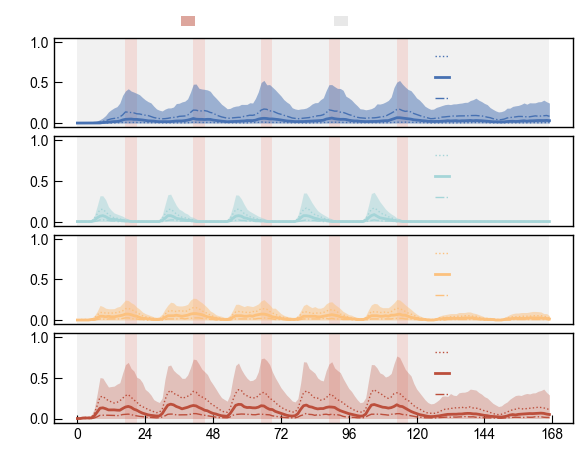

In [165]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharey = True, figsize=(6.7,5))
legend_elements = [Patch(facecolor=color_platte[7], alpha=0.5,
                         label=space_symbol),
                   Patch(facecolor='lightgrey', alpha=0.5,
                         label=space_symbol)]
fig.legend(handles=legend_elements,frameon=False,ncol=2,bbox_to_anchor=(0.75, 0.95))

ax[0].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2,  linewidth =0, color=color_platte[7], transform=ax[0].get_xaxis_transform())#,label='Grid Peak Hours')
ax[0].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[0].get_xaxis_transform())#,label='Grid Off-Peak Hours')
ax[0].fill_between(range(168),np.percentile(home/1000,5,axis=0),np.percentile(home/1000,95,axis=0),alpha=0.5, color = color_platte[1], linewidth=0)
ax[0].plot(np.percentile(home/1000,25,axis=0), linewidth=1, linestyle = 'dotted', c =color_platte[1],label=space_symbol)
ax[0].plot(np.percentile(home/1000,50,axis=0), linewidth=2,  c =color_platte[1],label=space_symbol)
ax[0].plot(np.percentile(home/1000,75,axis=0), linewidth=1, linestyle = 'dashdot', c =color_platte[1],label=space_symbol)
ax[0].set_xticks([])
ax[0].set_yticks([0,0.5,1],fontsize=12)
ax[0].legend(frameon=False)
ax[0].set_title(space_symbol, x=0.1, y=1.0, pad=-14)

ax[1].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2, linewidth =0,  color=color_platte[7], transform=ax[1].get_xaxis_transform())
ax[1].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[1].get_xaxis_transform())
ax[1].fill_between(range(168),np.percentile(work/1000,5,axis=0),np.percentile(work/1000,95,axis=0),alpha=0.5, color= color_platte[3], linewidth=0)
ax[1].plot(np.percentile(work/1000,75,axis=0), linewidth=1, linestyle = 'dotted', c =color_platte[3],label=space_symbol)
ax[1].plot(np.percentile(work/1000,50,axis=0), linewidth=2, c =color_platte[3],label=space_symbol)
ax[1].plot(np.percentile(work/1000,25,axis=0), linewidth=1, linestyle = 'dashdot',c =color_platte[3],label=space_symbol)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1],fontsize=12)
ax[1].legend(frameon=False)
ax[1].set_title(space_symbol,x=0.1, y=1.0, pad=-14)

ax[2].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2, linewidth =0,  color=color_platte[7], transform=ax[2].get_xaxis_transform())
ax[2].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[2].get_xaxis_transform())
ax[2].fill_between(range(168),np.percentile(other/1000,5,axis=0),np.percentile(other/1000,95,axis=0),alpha=0.5,color= color_platte[5], linewidth=0)
ax[2].plot(np.percentile(other/1000,75,axis=0), linewidth=1, linestyle = 'dotted', c =color_platte[5],label=space_symbol)
ax[2].plot(np.percentile(other/1000,50,axis=0), linewidth=2, c =color_platte[5],label=space_symbol)
ax[2].plot(np.percentile(other/1000,25,axis=0), linewidth=1, linestyle = 'dashdot',c =color_platte[5],label=space_symbol)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1],fontsize=12)
ax[2].legend(frameon=False)
ax[2].set_title(space_symbol,x=0.1, y=1.0, pad=-14)

ax[3].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2, linewidth =0,  color=color_platte[7],  transform=ax[3].get_xaxis_transform())
ax[3].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[3].get_xaxis_transform())
ax[3].fill_between(range(168),np.percentile(total/1000,5,axis=0),np.percentile(total/1000,95,axis=0),alpha=0.3,color= color_platte[7], linewidth=0)
ax[3].plot(np.percentile(total/1000,75,axis=0), linewidth=1, linestyle = 'dotted', c =color_platte[7],label=space_symbol)
ax[3].plot(np.percentile(total/1000,50,axis=0), linewidth=2, c =color_platte[7],label=space_symbol)
ax[3].plot(np.percentile(total/1000,25,axis=0), linewidth=1, linestyle = 'dashdot', c =color_platte[7],label=space_symbol)
ax[3].set_xticks([0,24,48,72,96,120,144,168],fontsize=12)
ax[3].set_yticks([0,0.5,1],fontsize=12)
ax[3].set_xlabel(space_symbol)
ax[3].set_ylabel(space_symbol,x=0.1, y=2.0)
ax[3].legend(frameon=False)
ax[3].set_title(space_symbol, x=0.1, y=1.0, pad=-14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.savefig('figures/fig2_temporal_load.pdf',dpi=900,transparent=True, bbox_inches='tight')
plt.show()

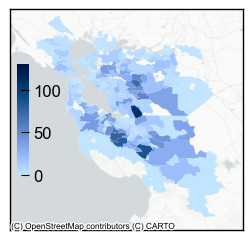

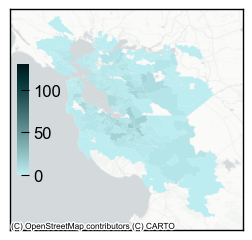

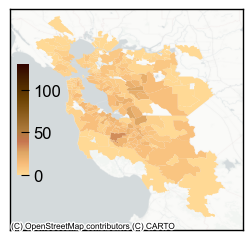

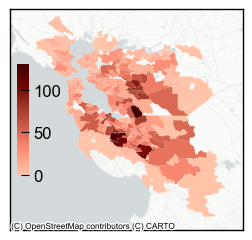

In [166]:
def visSecLoadGeo(total,name,color):
    df_user = total.reset_index().dropna()
    df_user['zipcode'] = df_user['index'].astype(int).astype(str)
    geozip = gpd.read_file("data/census/sfbay_zip.geojson")
    geozip_merge = geozip.merge(df_user,right_on='zipcode',left_on='ZCTA5CE10',how='left') 
    geozip_merge['zipcode'] = geozip_merge['ZCTA5CE10']
    geozip_merge['hour_sum'] = geozip_merge['hour_sum_o']/1000

    fig, ax = plt.subplots(figsize=(3,3))
    ax= geozip_merge.plot(ax = ax, column='hour_sum', cmap=color, legend=False,vmin=0,vmax=130)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-123, -121)
    ax.set_ylim(36.5, 38.4)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    scatter = ax.collections[0]
    #ax.set_title(name+' Weekly Needs [MWh]',x=0.5, y=0.85)
    ax.set_title(space_symbol,x=0.5, y=0.85)

    axins1 = inset_axes(
        ax,
        width="5%",  
        height="50%",  
        loc="center left",
    )

    cb = plt.colorbar(scatter, cax=axins1, shrink=1,orientation='vertical', label = space_symbol)
    cb.ax.tick_params(labelsize=12)
    cb.outline.set_visible(False)
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
    plt.savefig('figures/fig2_geo_load_'+str(name)+'.pdf',dpi=900,transparent=True, bbox_inches='tight')
    plt.show()

work['hour_sum_o'] = work.sum(axis=1)
home['hour_sum_o'] = home.sum(axis=1)
other['hour_sum_o'] = other.sum(axis=1)
total['hour_sum_o'] = total.sum(axis=1)
visSecLoadGeo(home,'Home',homecmap)
visSecLoadGeo(work,'Work',workcmap)
visSecLoadGeo(other,'Public',othercmap)
visSecLoadGeo(total,'Total',totalcmap)

# 4. Validation

In [167]:
def load_validation_file():
    n_driver_speech = pd.read_csv('data/speech/revalidation/pzip.csv',index_col=[0])
    n_driver_speech['Number'] =  (n_driver_speech['Weight']*27727).astype(int)
    p_g_speech = pd.read_csv('data/speech/revalidation/validation136_pg_zip_topzips_bydriverhome.csv',index_col=[0,1])

    total_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_total_bydriver_driverhome.csv',index_col=[0])
    mud_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_mud_l2_bydriver_driverhome.csv',index_col=[0])
    pub2_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_pub_l2_bydriver_driverhome.csv',index_col=[0])
    pub3_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_pub_l3_bydriver_driverhome.csv',index_col=[0])
    sfh_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_sfh_l2_bydriver_driverhome.csv',index_col=[0])
    work_min = pd.read_csv('data/speech/revalidation/normalized_load_by_zipcode_work_l2_bydriver_driverhome.csv',index_col=[0])
    home_min = mud_min + sfh_min
    other_min = pub2_min + pub3_min
    total_min_zip = pd.DataFrame()
    zipcodes = total_min.columns
    total_num=0
    
    for zipcode in zipcodes:
        zip_driver_num = 0
        zip_driver_totalnum = int(n_driver_speech[n_driver_speech['Zip']==int(zipcode)]['Number'].values[0])
        for i in range(136):
            group_num = int(zip_driver_totalnum*p_g_speech[zipcode].values[i])
            zip_driver_num = zip_driver_num + group_num
        zip_driver_num = int(zip_driver_num*7995/8943)
        total_min_zip[zipcode] = (total_min[zipcode]*zip_driver_num)[59::60].values
        total_num = total_num + zip_driver_num
    print(total_num)

    home_min_zip = pd.DataFrame()
    zipcodes = home_min.columns
    for zipcode in zipcodes:
        zip_driver_num = 0
        zip_driver_totalnum = int(n_driver_speech[n_driver_speech['Zip']==int(zipcode)]['Number'].values[0])
        for i in range(136):
            group_num = int(zip_driver_totalnum*p_g_speech[zipcode].values[i])
            zip_driver_num = zip_driver_num + group_num
        zip_driver_num = int(zip_driver_num*7995/8943)
        home_min_zip[zipcode] = (home_min[zipcode]*zip_driver_num)[59::60].values

    work_min_zip = pd.DataFrame()
    zipcodes = work_min.columns
    for zipcode in zipcodes:
        zip_driver_num = 0
        zip_driver_totalnum = int(n_driver_speech[n_driver_speech['Zip']==int(zipcode)]['Number'].values[0])
        for i in range(136):
            group_num = int(zip_driver_totalnum*p_g_speech[zipcode].values[i])
            zip_driver_num = zip_driver_num + group_num
        zip_driver_num = int(zip_driver_num*7995/8943)
        work_min_zip[zipcode] = (work_min[zipcode]*zip_driver_num)[59::60].values

    other_min_zip = pd.DataFrame()
    zipcodes = other_min.columns
    for zipcode in zipcodes:
        zip_driver_num = 0
        zip_driver_totalnum = int(n_driver_speech[n_driver_speech['Zip']==int(zipcode)]['Number'].values[0])
        for i in range(136):
            group_num = int(zip_driver_totalnum*p_g_speech[zipcode].values[i])
            zip_driver_num = zip_driver_num + group_num
        zip_driver_num = int(zip_driver_num*7995/8943)
        other_min_zip[zipcode] = (other_min[zipcode]*zip_driver_num)[59::60].values
    
    return total_min_zip,home_min_zip,work_min_zip,other_min_zip

def getSimulation():
    user_select = pickle.load(open('results/selected_EV_Drivers_' + str(0) + 'p.pkl', 'rb'), encoding='bytes')
    df_user_inf = pickle.load(open('results/df_user_inf_update_'+str(0)+'.pkl', 'rb'), encoding='bytes')
    df_user_group = pd.read_csv('results/user_group_update_'+str(0)+'.csv')
    df_user_inf = df_user_inf[df_user_inf['userID'].isin(user_select)]
    df_user_group = df_user_group[df_user_group['userID'].isin(user_select)]
    df_user_inf['personGroup'] = df_user_group['personGroup'].values
    
    p_g_speech = pd.read_csv('data/speech/revalidation/validation136_pg_zip_topzips_bydriverhome.csv',index_col=[0,1])
    n_driver_speech = pd.read_csv('data/speech/revalidation/pzip.csv',index_col=[0])
    zipcode_val_list = p_g_speech.columns.values

    picked_user_id = []
    null_count = 0
    for j in zipcode_val_list:
        for i in range(136):
            group_list = df_user_inf[(df_user_inf['personGroup']==i)&(df_user_inf['homeZipcode']==j)]['userID'].values
            n_driver = n_driver_speech[n_driver_speech['Zip']==int(j)]['Weight'].values*27727
            group_num = int(n_driver*p_g_speech[j].values[i])
            try:
                picked_user_id += list(np.random.choice(group_list, group_num))
            except:
                null_count += group_num
    
    df = pd.read_csv('results/simulated_session_update_'+str(0)+'.csv')
    df = df[df['id'].isin(user_select)]
    df_charge = pd.DataFrame()
    for user in picked_user_id:
        df_charge = pd.concat([df_charge, df[df['id']==user]])
    df_charge = df_charge.merge(df_user_inf, left_on='id', right_on='userID')

    day_ave = 7
    home_l2_rate = 6.6
    work_l2_rate = 6.6
    mud_l2_rate = 6.6
    public_l2_rate = 6.6
    home_l1_rate = 1.2
    public_l3_rate = 50

    df = df_charge

    df_home_l1 = df[(df['session_type']=='home_l1')&(df['depature_time']<=144*day_ave)]
    df_home_l1['charge_end_time'] = np.minimum(df_home_l1['arrive_time']+(df_home_l1['session_energy']/home_l1_rate)*6,df_home_l1['depature_time'])

    df_home_l2 = df[(df['session_type']=='home_l2')&(df['depature_time']<=144*day_ave)]
    df_home_l2['charge_end_time'] = np.minimum(df_home_l2['arrive_time']+(df_home_l2['session_energy']/home_l2_rate)*6,df_home_l2['depature_time'])
    
    df_home_l3 = df[(df['session_type']=='mud_l2')&(df['depature_time']<=144*day_ave)]
    df_home_l3['charge_end_time'] = np.minimum(df_home_l3['arrive_time']+(df_home_l3['session_energy']/mud_l2_rate)*6,df_home_l3['depature_time'])
    df_work = df[(df['session_type']=='work_l2')&(df['depature_time']<=144*day_ave)]
    df_work['charge_end_time'] = np.minimum(df_work['arrive_time']+(df_work['session_energy']/work_l2_rate)*6,df_work['depature_time'])
    
    df_other_l2 = df[(df['session_type']=='public_l2')&(df['depature_time']<=144*day_ave)]
    df_other_l2['charge_end_time'] = np.minimum(df_other_l2['arrive_time']+(df_other_l2['session_energy']/public_l2_rate)*6,df_other_l2['depature_time'])
    df_other_l3 = df[(df['session_type']=='public_l3')&(df['depature_time']<=144*day_ave)]
    df_other_l3['charge_end_time'] = np.minimum(df_other_l3['arrive_time']+(df_other_l3['session_energy']/public_l3_rate)*6,df_other_l3['depature_time'])

    zipcode_list = df['homeZipcode'].unique()
    home_demand_l1 = {}; home_demand_l2 = {}; home_demand_l3 = {}; work_demand = {}; other_demand_l2 = {}; other_demand_l3 = {}; 
    total_demand = {}; home_demand = {}; other_demand = {}
    
    for zipcode in zipcode_list:
        df_home_1 = df_home_l1[(df_home_l1['session_energy']!=0)&(df_home_l1['homeZipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),24*day_ave))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l1_rate
        home_demand_l1[zipcode] = np.sum(home_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        df_home_1 = df_home_l2[(df_home_l2['session_energy']!=0)&(df_home_l2['homeZipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),24*day_ave))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l2_rate
        home_demand_l2[zipcode] = np.sum(home_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        df_home_1 = df_home_l3[(df_home_l3['session_energy']!=0)&(df_home_l3['homeZipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),24*day_ave))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = mud_l2_rate
        home_demand_l3[zipcode] = np.sum(home_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        df_work_1 = df_work[(df_work['session_energy']!=0)&(df_work['homeZipcode']==zipcode)]
        start_time =(df_work_1['arrive_time']/6).astype(int).values
        end_time = (df_work_1['charge_end_time']/6).astype(int).values
        work_matrix = np.zeros((len(df_work_1),24*day_ave))
        for i in range(len(start_time)):
            work_matrix[i,start_time[i]:end_time[i]+1] = work_l2_rate
        work_demand[zipcode] = np.sum(work_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        df_other_1 = df_other_l2[(df_other_l2['session_energy']!=0)&(df_other_l2['homeZipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),24*day_ave))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l2_rate
        other_demand_l2[zipcode] = np.sum(other_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        df_other_1 = df_other_l3[(df_other_l3['session_energy']!=0)&(df_other_l3['homeZipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),24*day_ave))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l3_rate
        other_demand_l3[zipcode] = np.sum(other_matrix,axis=0).reshape(day_ave,24).mean(axis=0)

        home_demand[zipcode] = home_demand_l1[zipcode]+home_demand_l2[zipcode]+home_demand_l3[zipcode]
        other_demand[zipcode] = other_demand_l3[zipcode]+other_demand_l2[zipcode]
        total_demand[zipcode] = work_demand[zipcode]+other_demand[zipcode]+home_demand[zipcode]

    home = pd.DataFrame.from_dict(home_demand, orient='index')
    work = pd.DataFrame.from_dict(work_demand, orient='index')
    other = pd.DataFrame.from_dict(other_demand, orient='index')
    total = pd.DataFrame.from_dict(total_demand, orient='index')

    home1 = pd.DataFrame(home); home1=home1[home1.apply(np.sum,axis=1)!=0] 
    work1 = pd.DataFrame(work); work1=work1[work1.apply(np.sum,axis=1)!=0] 
    other1 = pd.DataFrame(other); other1=other1[other1.apply(np.sum,axis=1)!=0] 
    total1 = pd.DataFrame(total); total1=total1[total1.apply(np.sum,axis=1)!=0] 

    return home1, work1, other1, total1

def visValidation(home1, work1, other1, total1):
    total_min_zip,home_min_zip,work_min_zip,other_min_zip = load_validation_file()
    capsize = 2; color1 = color_platte[1]; color2 = color_platte[5]
    fig, ax = plt.subplots(nrows=2, ncols=2, sharey = False, figsize=(6,3))

    max = np.percentile(home1,75,axis=0)
    min = np.percentile(home1,25,axis=0)
    y=np.percentile(home1,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[1,1].errorbar(range(24),y,yerr,color=color1,fmt='s',markersize= mymarkersize,capsize=capsize,label=space_symbol)
    ax[1,1].plot(np.percentile(home1,50,axis=0),c=color1, linewidth = 2)
    max = np.percentile(home_min_zip.T,75,axis=0)
    min = np.percentile(home_min_zip.T,25,axis=0)
    y=np.percentile(home_min_zip.T,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[1,1].errorbar(range(24),y,yerr,color=color2,fmt='s',markersize= mymarkersize,capsize=capsize,label=space_symbol)
    ax[1,1].plot(np.percentile(home_min_zip.T,50,axis=0),c=color2, linewidth = 2)

    max = np.percentile(work1,75,axis=0)
    min = np.percentile(work1,25,axis=0)
    y=np.percentile(work1,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[0,1].errorbar(range(24),y,yerr,color=color1,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[0,1].plot(y,c=color1, linewidth = 2)
    max = np.percentile(work_min_zip.T,75,axis=0)
    min = np.percentile(work_min_zip.T,25,axis=0)
    y=np.percentile(work_min_zip.T,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[0,1].errorbar(range(24),y,yerr,color=color2,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[0,1].plot(y,c=color2, linewidth = 2)

    max = np.percentile(other1,75,axis=0)
    min = np.percentile(other1,25,axis=0)
    y=np.percentile(other1,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[1,0].errorbar(range(24),y,yerr,color=color1,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[1,0].plot(y,c=color1, linewidth = 2)
    max = np.percentile(other_min_zip.T,75,axis=0)
    min = np.percentile(other_min_zip.T,25,axis=0)
    y=np.percentile(other_min_zip.T,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[1,0].errorbar(range(24),y,yerr,color=color2,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[1,0].plot(y,c=color2, linewidth = 2)

    max = np.percentile(total1,75,axis=0)
    min = np.percentile(total1,25,axis=0)
    y=np.percentile(total1,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[0,0].errorbar(range(24),y,yerr,color=color1,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[0,0].plot(y,c=color1, linewidth = 2)
    max = np.percentile(total_min_zip.T,75,axis=0)
    min = np.percentile(total_min_zip.T,25,axis=0)
    y=np.percentile(total_min_zip.T,50,axis=0)
    uplim = max-y; lowlim = y-min
    yerr = np.concatenate([[lowlim],[uplim]])
    ax[0,0].errorbar(range(24),y,yerr,color=color2,fmt='s',markersize= mymarkersize,capsize=capsize)
    ax[0,0].plot(y,c=color2, linewidth = 2)

    ax[1,1].set_ylim(0,40)
    ax[0,1].set_ylim(0,400) 
    ax[1,0].set_ylim(0,40)
    ax[0,0].set_ylim(0,400)

    ax[1,1].set_title(space_symbol,x=0.3, y=1.0, pad=-14)
    ax[0,1].set_title(space_symbol,x=0.3, y=1.0, pad=-14)
    ax[1,0].set_title(space_symbol,x=0.3, y=1.0, pad=-14)
    ax[0,0].set_title(space_symbol,x=0.2, y=1.0, pad=-14)
    ax[1,0].set_xlabel(space_symbol,x=1, y=1.0)
    ax[1,0].set_ylabel(space_symbol,x=0, y=1.0)

    ax[0,0].tick_params(labelsize=10)
    ax[0,1].tick_params(labelsize=10)
    ax[1,0].tick_params(labelsize=10)
    ax[1,1].tick_params(labelsize=10)

    fig.legend(loc='lower center', bbox_to_anchor=(-0., 0.93, 1., .1), ncol=2, fancybox=True, shadow=True, frameon=False)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    plt.savefig('figures/fig2_temporal_validation.pdf',format='pdf',transparent=True,bbox_inches='tight')
    plt.show()
    

7985


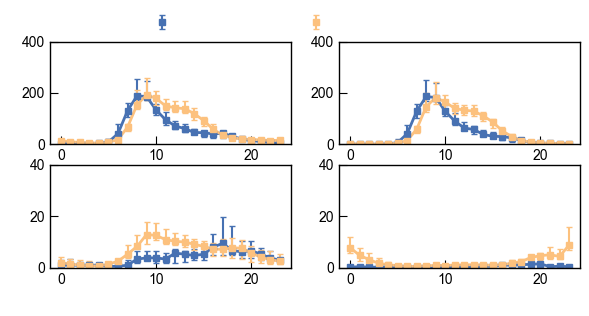

In [168]:
home,work,other,total = getSimulation()
visValidation(home,work,other,total)

- print needed data

In [45]:
# section 2
df = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
home, work, other, total = simEVLoad(year,df)
total['hour_sum_o'] = total.sum(axis=1)
print('The max weekly needs [MWh]',np.sort(total['hour_sum_o']/1000)[-1])
print('The min weekly needs [MWh]',np.sort(total['hour_sum_o']/1000)[0])
print('The mean weekly needs [MWh]',np.mean(total['hour_sum_o']/1000))
print('The variance weekly needs [MWh]',np.std(total['hour_sum_o']/1000))
home['hour_sum_o'] = home.sum(axis=1)
print('The max weekly needs [MWh]',np.sort(home['hour_sum_o']/1000)[-1])
print('The min weekly needs [MWh]',np.sort(home['hour_sum_o']/1000)[0])
print('The mean weekly needs [MWh]',np.mean(home['hour_sum_o']/1000))
print('The variance weekly needs [MWh]',np.std(home['hour_sum_o']/1000))
work['hour_sum_o'] = work.sum(axis=1)
print('The max weekly needs [MWh]',np.sort(work['hour_sum_o']/1000)[-1])
print('The min weekly needs [MWh]',np.sort(work['hour_sum_o']/1000)[0])
print('The mean weekly needs [MWh]',np.mean(work['hour_sum_o']/1000))
print('The variance weekly needs [MWh]',np.std(work['hour_sum_o']/1000))
other['hour_sum_o'] = other.sum(axis=1)
print('The max weekly needs [MWh]',np.sort(other['hour_sum_o']/1000)[-1])
print('The min weekly needs [MWh]',np.sort(other['hour_sum_o']/1000)[0])
print('The mean weekly needs [MWh]',np.mean(other['hour_sum_o']/1000))
print('The variance weekly needs [MWh]',np.std(other['hour_sum_o']/1000))

The max weekly needs [MWh] 132.36680000000004
The min weekly needs [MWh] 0.0
The mean weekly needs [MWh] 21.868335021097057
The variance weekly needs [MWh] 22.767442786331056
The max weekly needs [MWh] 107.4744
The min weekly needs [MWh] 0.0
The mean weekly needs [MWh] 11.46446835443038
The variance weekly needs [MWh] 16.543700739950815
The max weekly needs [MWh] 19.080600000000015
The min weekly needs [MWh] 0.0
The mean weekly needs [MWh] 3.3945999999999996
The variance weekly needs [MWh] 3.5269823217194487
The max weekly needs [MWh] 32.71619999999999
The min weekly needs [MWh] 0.0
The mean weekly needs [MWh] 7.009266666666663
The variance weekly needs [MWh] 6.080734258553855


In [41]:
total_pop = pd.read_csv('/home/jiaman/ns_ev_week/data/census/ACS0101/ACSST5Y2019.S0101-Data.csv',skiprows=1)[['Geographic Area Name','Estimate!!Total!!Total population']]
total_pop['zipcode'] = total_pop['Geographic Area Name'].str.split('ZCTA5 ',expand=True)[1]
total_pop['pop'] = total_pop['Estimate!!Total!!Total population']
total_pop = total_pop[total_pop['zipcode'].isin(df['stay_zipcode'].dropna().unique().astype(int).astype(str))][['zipcode','pop']]
total['zipcode'] = total.reset_index()['index'].values
total_pop['zipcode'] = total_pop['zipcode'].astype(int)
demand_pop = total_pop.merge(total,left_on = 'zipcode',right_on='zipcode')
demand_pop['pop'].mean()

29930.90254237288